In [47]:
import os
print(os.listdir('../ML Project/flowers-recognition/flowers'))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [48]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from tensorflow.python.keras.applications.resnet50 import preprocess_input, decode_predictions

In [49]:
base_path = '../ML Project/flowers/flowers'

categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [50]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [51]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [769, 1055, 784, 734, 984]


In [52]:
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [53]:
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [769, 1052, 784, 734, 984]


In [54]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

125,134 is the min shape for daisy
98,134 is the min shape for dandelion
80,150 is the min shape for rose
134,152 is the min shape for sunflower
134,134 is the min shape for tulip


In [55]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

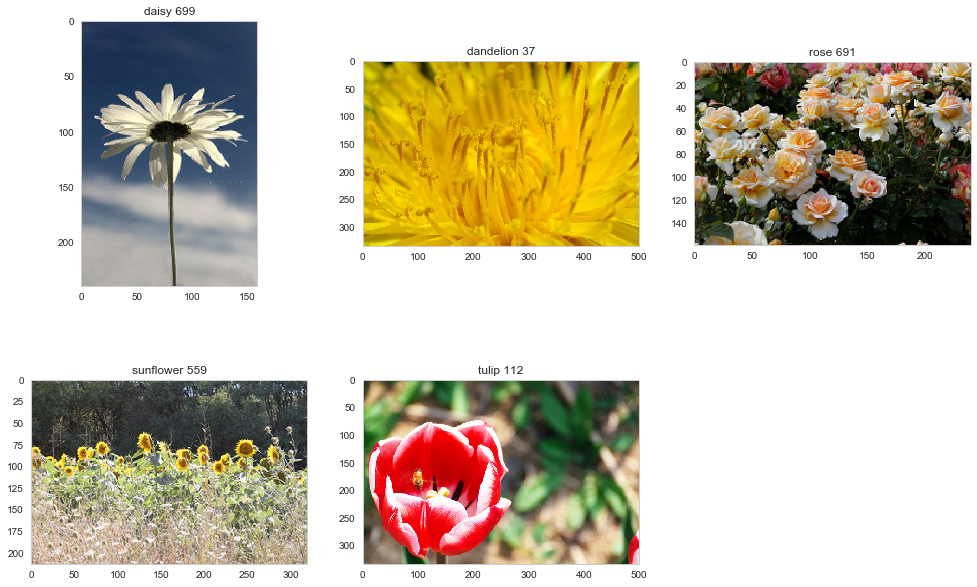

In [56]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

(333, 500, 3)
(256, 256, 3)


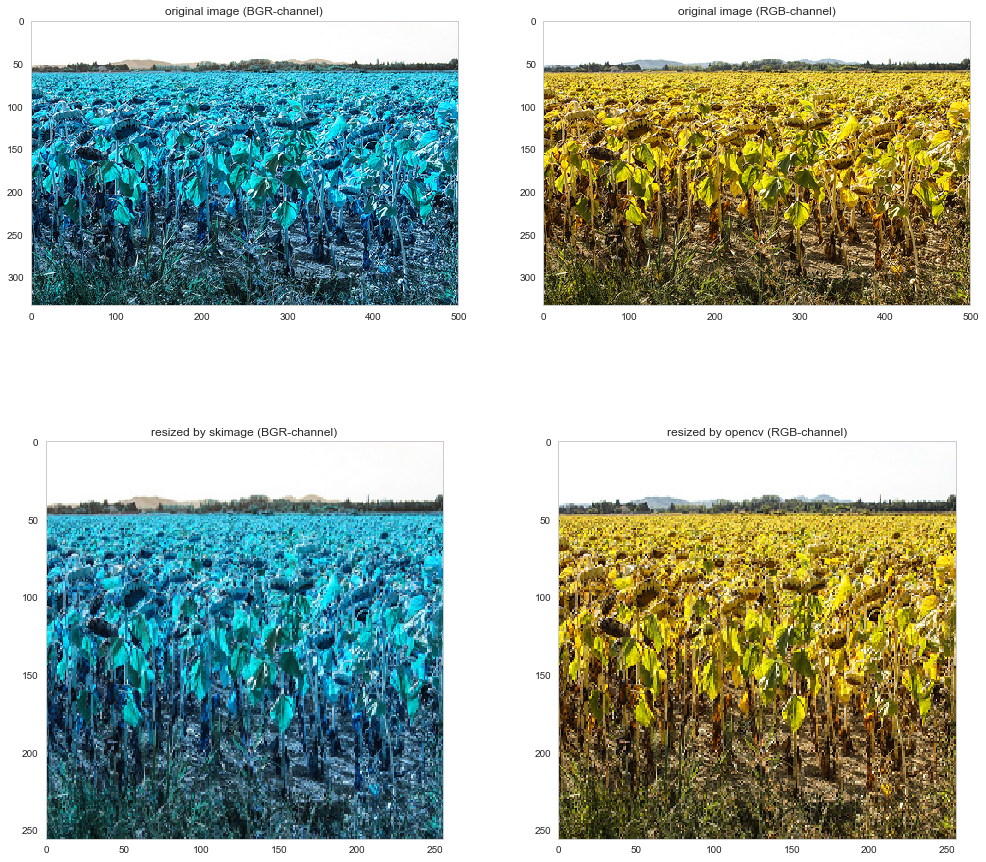

In [57]:
img_width, img_height = 256, 256

img = images[3][659]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

In [58]:
# Apply resize to all images
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

In [59]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.75, test_size=0.25)
    train_images.append(train)
    val_images.append(test)

In [60]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[576, 789, 588, 550, 738]
sum of train images: 3241
[193, 263, 196, 184, 246]
sum of val_images: 1082


In [61]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [62]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (3241, 256, 256, 3)
train labels: (3241,)

After converting
train data: (3241, 256, 256, 3)
train labels: (3241, 5)


In [63]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [64]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (3241, 256, 256, 3)
shape of train labels: (3241, 5)
shape of val data: (860, 256, 256, 3)
shape of val labels: (860, 5)


In [65]:
    model = Sequential()

    model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(categories), activation='softmax'))

    model.layers[0].trainable = False

In [66]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
__________

In [68]:
image_size = 224
batch_size = 30
epochs = 30

In [69]:
generator = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=preprocess_input
        )


train_data_generator = generator.flow(train_data,
                                                train_labels,
                                                batch_size=batch_size,
                                                )

validation_data_generator = generator.flow(val_data,
                                                val_labels,
                                                batch_size=batch_size,
                                                )

In [70]:
History = model.fit_generator(
                generator=train_data_generator, 
                steps_per_epoch=len(train_data)//batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
                epochs=epochs, 
                validation_steps=len(val_data)//batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
                validation_data=validation_data_generator, 
                verbose=1
                )

Epoch 1/30
108/108 [==============================] - ETA: 37:53 - loss: 1.6094 - acc: 0.0000e+ - ETA: 1:06:29 - loss: 2.0401 - acc: 0.1000 - ETA: 1:12:52 - loss: 1.7855 - acc: 0.26 - ETA: 1:16:20 - loss: 1.5594 - acc: 0.38 - ETA: 1:17:18 - loss: 1.5486 - acc: 0.44 - ETA: 1:17:57 - loss: 1.8684 - acc: 0.45 - ETA: 1:17:50 - loss: 1.8793 - acc: 0.48 - ETA: 1:18:33 - loss: 1.8713 - acc: 0.50 - ETA: 1:18:20 - loss: 1.8410 - acc: 0.53 - ETA: 1:16:28 - loss: 1.8219 - acc: 0.55 - ETA: 1:13:01 - loss: 1.8571 - acc: 0.56 - ETA: 1:10:07 - loss: 2.0175 - acc: 0.57 - ETA: 1:07:44 - loss: 1.9957 - acc: 0.58 - ETA: 1:05:37 - loss: 1.9761 - acc: 0.58 - ETA: 1:03:39 - loss: 1.8797 - acc: 0.60 - ETA: 1:01:44 - loss: 1.7962 - acc: 0.62 - ETA: 59:35 - loss: 1.8353 - acc: 0.6176 - ETA: 57:35 - loss: 1.8235 - acc: 0.62 - ETA: 55:43 - loss: 1.8058 - acc: 0.63 - ETA: 53:58 - loss: 1.7591 - acc: 0.64 - ETA: 52:22 - loss: 1.7888 - acc: 0.64 - ETA: 50:53 - loss: 1.7735 - acc: 0.64 - ETA: 49:28 - loss: 1.7843 - 

108/108 [==============================] - ETA: 38:21 - loss: 0.4180 - acc: 0.90 - ETA: 39:58 - loss: 0.4020 - acc: 0.91 - ETA: 39:15 - loss: 0.3699 - acc: 0.91 - ETA: 38:40 - loss: 0.3414 - acc: 0.90 - ETA: 38:27 - loss: 0.3633 - acc: 0.88 - ETA: 38:06 - loss: 0.3669 - acc: 0.88 - ETA: 37:34 - loss: 0.3613 - acc: 0.88 - ETA: 37:10 - loss: 0.3343 - acc: 0.89 - ETA: 36:40 - loss: 0.3245 - acc: 0.88 - ETA: 36:18 - loss: 0.3147 - acc: 0.89 - ETA: 36:00 - loss: 0.3406 - acc: 0.89 - ETA: 35:38 - loss: 0.3555 - acc: 0.89 - ETA: 35:15 - loss: 0.3592 - acc: 0.88 - ETA: 34:48 - loss: 0.3425 - acc: 0.89 - ETA: 34:23 - loss: 0.3422 - acc: 0.89 - ETA: 34:00 - loss: 0.3436 - acc: 0.89 - ETA: 33:35 - loss: 0.3416 - acc: 0.89 - ETA: 33:12 - loss: 0.3406 - acc: 0.89 - ETA: 32:50 - loss: 0.3310 - acc: 0.89 - ETA: 32:26 - loss: 0.3196 - acc: 0.89 - ETA: 32:03 - loss: 0.3193 - acc: 0.89 - ETA: 31:40 - loss: 0.3111 - acc: 0.89 - ETA: 31:17 - loss: 0.3100 - acc: 0.89 - ETA: 30:56 - loss: 0.3124 - acc: 0.89

108/108 [==============================] - ETA: 38:59 - loss: 0.2324 - acc: 0.93 - ETA: 38:21 - loss: 0.1890 - acc: 0.93 - ETA: 37:56 - loss: 0.1753 - acc: 0.93 - ETA: 38:36 - loss: 0.2677 - acc: 0.90 - ETA: 38:03 - loss: 0.2311 - acc: 0.92 - ETA: 37:44 - loss: 0.2312 - acc: 0.91 - ETA: 37:15 - loss: 0.2192 - acc: 0.92 - ETA: 36:52 - loss: 0.2043 - acc: 0.92 - ETA: 36:29 - loss: 0.1866 - acc: 0.93 - ETA: 36:02 - loss: 0.1832 - acc: 0.93 - ETA: 35:39 - loss: 0.2016 - acc: 0.93 - ETA: 35:15 - loss: 0.1973 - acc: 0.93 - ETA: 34:50 - loss: 0.1923 - acc: 0.93 - ETA: 34:29 - loss: 0.1916 - acc: 0.93 - ETA: 34:05 - loss: 0.1847 - acc: 0.93 - ETA: 33:41 - loss: 0.1854 - acc: 0.93 - ETA: 33:19 - loss: 0.2028 - acc: 0.92 - ETA: 32:55 - loss: 0.2069 - acc: 0.92 - ETA: 32:32 - loss: 0.2129 - acc: 0.92 - ETA: 32:12 - loss: 0.2124 - acc: 0.92 - ETA: 31:49 - loss: 0.2116 - acc: 0.92 - ETA: 31:27 - loss: 0.2100 - acc: 0.92 - ETA: 31:04 - loss: 0.2182 - acc: 0.92 - ETA: 30:41 - loss: 0.2251 - acc: 0.92

108/108 [==============================] - ETA: 38:27 - loss: 0.1585 - acc: 0.93 - ETA: 38:22 - loss: 0.3746 - acc: 0.90 - ETA: 37:49 - loss: 0.3437 - acc: 0.90 - ETA: 37:42 - loss: 0.2923 - acc: 0.91 - ETA: 37:23 - loss: 0.2527 - acc: 0.92 - ETA: 37:33 - loss: 0.2849 - acc: 0.92 - ETA: 37:10 - loss: 0.2639 - acc: 0.92 - ETA: 36:43 - loss: 0.2525 - acc: 0.92 - ETA: 36:21 - loss: 0.2520 - acc: 0.92 - ETA: 36:02 - loss: 0.2448 - acc: 0.92 - ETA: 35:37 - loss: 0.2438 - acc: 0.92 - ETA: 35:12 - loss: 0.2411 - acc: 0.92 - ETA: 34:50 - loss: 0.2368 - acc: 0.92 - ETA: 34:26 - loss: 0.2441 - acc: 0.92 - ETA: 34:04 - loss: 0.2314 - acc: 0.92 - ETA: 33:41 - loss: 0.2293 - acc: 0.92 - ETA: 33:17 - loss: 0.2393 - acc: 0.92 - ETA: 32:59 - loss: 0.2398 - acc: 0.92 - ETA: 32:35 - loss: 0.2334 - acc: 0.92 - ETA: 32:13 - loss: 0.2281 - acc: 0.92 - ETA: 31:51 - loss: 0.2405 - acc: 0.92 - ETA: 31:28 - loss: 0.2301 - acc: 0.92 - ETA: 31:04 - loss: 0.2291 - acc: 0.93 - ETA: 30:42 - loss: 0.2280 - acc: 0.92

108/108 [==============================] - ETA: 48:44 - loss: 0.3745 - acc: 0.86 - ETA: 47:52 - loss: 0.2635 - acc: 0.90 - ETA: 46:56 - loss: 0.1976 - acc: 0.92 - ETA: 46:08 - loss: 0.1749 - acc: 0.92 - ETA: 36:50 - loss: 0.4265 - acc: 0.74 - ETA: 37:50 - loss: 0.3682 - acc: 0.77 - ETA: 38:47 - loss: 0.3232 - acc: 0.80 - ETA: 39:35 - loss: 0.2853 - acc: 0.83 - ETA: 39:54 - loss: 0.2647 - acc: 0.84 - ETA: 39:52 - loss: 0.2445 - acc: 0.86 - ETA: 39:37 - loss: 0.2396 - acc: 0.86 - ETA: 39:30 - loss: 0.2293 - acc: 0.87 - ETA: 39:38 - loss: 0.2388 - acc: 0.87 - ETA: 39:36 - loss: 0.2255 - acc: 0.88 - ETA: 39:32 - loss: 0.2116 - acc: 0.88 - ETA: 39:20 - loss: 0.1996 - acc: 0.89 - ETA: 39:29 - loss: 0.1975 - acc: 0.90 - ETA: 39:18 - loss: 0.2025 - acc: 0.90 - ETA: 39:15 - loss: 0.1953 - acc: 0.90 - ETA: 38:51 - loss: 0.1936 - acc: 0.90 - ETA: 38:29 - loss: 0.1875 - acc: 0.91 - ETA: 38:04 - loss: 0.1838 - acc: 0.91 - ETA: 37:41 - loss: 0.1841 - acc: 0.91 - ETA: 37:18 - loss: 0.1880 - acc: 0.90

108/108 [==============================] - ETA: 38:53 - loss: 0.0654 - acc: 1.00 - ETA: 38:48 - loss: 0.2463 - acc: 0.91 - ETA: 38:20 - loss: 0.2455 - acc: 0.92 - ETA: 37:56 - loss: 0.2023 - acc: 0.93 - ETA: 37:38 - loss: 0.1886 - acc: 0.93 - ETA: 37:11 - loss: 0.1635 - acc: 0.94 - ETA: 36:53 - loss: 0.1562 - acc: 0.94 - ETA: 36:28 - loss: 0.1828 - acc: 0.93 - ETA: 36:06 - loss: 0.1784 - acc: 0.93 - ETA: 36:08 - loss: 0.1873 - acc: 0.93 - ETA: 35:45 - loss: 0.2121 - acc: 0.92 - ETA: 35:23 - loss: 0.2058 - acc: 0.92 - ETA: 34:59 - loss: 0.1945 - acc: 0.92 - ETA: 34:36 - loss: 0.1849 - acc: 0.93 - ETA: 34:16 - loss: 0.1734 - acc: 0.93 - ETA: 33:53 - loss: 0.1761 - acc: 0.93 - ETA: 33:29 - loss: 0.1886 - acc: 0.92 - ETA: 33:09 - loss: 0.1896 - acc: 0.92 - ETA: 32:45 - loss: 0.1854 - acc: 0.92 - ETA: 32:24 - loss: 0.1842 - acc: 0.93 - ETA: 32:01 - loss: 0.1866 - acc: 0.93 - ETA: 31:39 - loss: 0.1866 - acc: 0.93 - ETA: 31:17 - loss: 0.1865 - acc: 0.93 - ETA: 30:54 - loss: 0.1855 - acc: 0.93

108/108 [==============================] - ETA: 38:51 - loss: 0.2597 - acc: 0.90 - ETA: 38:36 - loss: 0.1912 - acc: 0.93 - ETA: 38:19 - loss: 0.1549 - acc: 0.94 - ETA: 37:54 - loss: 0.1886 - acc: 0.92 - ETA: 37:31 - loss: 0.1818 - acc: 0.92 - ETA: 37:02 - loss: 0.2491 - acc: 0.90 - ETA: 36:39 - loss: 0.2204 - acc: 0.90 - ETA: 31:55 - loss: 0.3407 - acc: 0.92 - ETA: 32:05 - loss: 0.3511 - acc: 0.91 - ETA: 32:05 - loss: 0.3206 - acc: 0.92 - ETA: 32:04 - loss: 0.3010 - acc: 0.92 - ETA: 32:15 - loss: 0.2898 - acc: 0.92 - ETA: 32:06 - loss: 0.2733 - acc: 0.92 - ETA: 31:59 - loss: 0.2647 - acc: 0.92 - ETA: 31:49 - loss: 0.2562 - acc: 0.92 - ETA: 31:37 - loss: 0.2504 - acc: 0.92 - ETA: 31:24 - loss: 0.2538 - acc: 0.92 - ETA: 31:12 - loss: 0.2430 - acc: 0.92 - ETA: 31:00 - loss: 0.2313 - acc: 0.93 - ETA: 30:44 - loss: 0.2235 - acc: 0.93 - ETA: 30:28 - loss: 0.2145 - acc: 0.93 - ETA: 30:11 - loss: 0.2069 - acc: 0.94 - ETA: 29:52 - loss: 0.2044 - acc: 0.94 - ETA: 29:35 - loss: 0.2036 - acc: 0.94

108/108 [==============================] - ETA: 41:49 - loss: 0.0591 - acc: 0.96 - ETA: 41:34 - loss: 0.0909 - acc: 0.95 - ETA: 43:10 - loss: 0.1186 - acc: 0.93 - ETA: 43:25 - loss: 0.2305 - acc: 0.92 - ETA: 43:30 - loss: 0.2115 - acc: 0.92 - ETA: 43:29 - loss: 0.1996 - acc: 0.93 - ETA: 43:19 - loss: 0.1749 - acc: 0.94 - ETA: 43:00 - loss: 0.1569 - acc: 0.95 - ETA: 42:41 - loss: 0.1609 - acc: 0.95 - ETA: 42:21 - loss: 0.1522 - acc: 0.95 - ETA: 41:59 - loss: 0.1425 - acc: 0.95 - ETA: 41:38 - loss: 0.1412 - acc: 0.95 - ETA: 41:14 - loss: 0.1522 - acc: 0.95 - ETA: 40:51 - loss: 0.1628 - acc: 0.95 - ETA: 40:28 - loss: 0.1566 - acc: 0.94 - ETA: 40:08 - loss: 0.1607 - acc: 0.94 - ETA: 39:43 - loss: 0.1535 - acc: 0.95 - ETA: 39:17 - loss: 0.1524 - acc: 0.95 - ETA: 38:50 - loss: 0.1464 - acc: 0.95 - ETA: 38:23 - loss: 0.1461 - acc: 0.95 - ETA: 37:59 - loss: 0.1409 - acc: 0.95 - ETA: 37:37 - loss: 0.1428 - acc: 0.95 - ETA: 37:07 - loss: 0.1420 - acc: 0.95 - ETA: 36:42 - loss: 0.1457 - acc: 0.95

108/108 [==============================] - ETA: 40:44 - loss: 0.0714 - acc: 0.96 - ETA: 41:59 - loss: 0.1314 - acc: 0.93 - ETA: 41:17 - loss: 0.1600 - acc: 0.93 - ETA: 40:37 - loss: 0.1258 - acc: 0.95 - ETA: 40:28 - loss: 0.1145 - acc: 0.95 - ETA: 39:36 - loss: 0.1018 - acc: 0.96 - ETA: 38:48 - loss: 0.1083 - acc: 0.95 - ETA: 38:10 - loss: 0.1040 - acc: 0.95 - ETA: 37:32 - loss: 0.1025 - acc: 0.95 - ETA: 37:00 - loss: 0.0993 - acc: 0.96 - ETA: 36:30 - loss: 0.1037 - acc: 0.96 - ETA: 35:58 - loss: 0.1064 - acc: 0.95 - ETA: 35:31 - loss: 0.1183 - acc: 0.95 - ETA: 35:04 - loss: 0.1156 - acc: 0.95 - ETA: 34:37 - loss: 0.1276 - acc: 0.95 - ETA: 34:37 - loss: 0.1220 - acc: 0.95 - ETA: 34:15 - loss: 0.1177 - acc: 0.95 - ETA: 33:50 - loss: 0.1156 - acc: 0.95 - ETA: 33:23 - loss: 0.1157 - acc: 0.95 - ETA: 32:59 - loss: 0.1306 - acc: 0.95 - ETA: 32:38 - loss: 0.1304 - acc: 0.95 - ETA: 32:13 - loss: 0.1254 - acc: 0.95 - ETA: 31:50 - loss: 0.1205 - acc: 0.95 - ETA: 31:24 - loss: 0.1262 - acc: 0.95

108/108 [==============================] - ETA: 42:36 - loss: 0.0236 - acc: 1.00 - ETA: 41:20 - loss: 0.0731 - acc: 0.96 - ETA: 41:11 - loss: 0.0676 - acc: 0.96 - ETA: 40:37 - loss: 0.0892 - acc: 0.96 - ETA: 40:16 - loss: 0.0888 - acc: 0.96 - ETA: 40:16 - loss: 0.0975 - acc: 0.96 - ETA: 39:50 - loss: 0.1335 - acc: 0.95 - ETA: 39:40 - loss: 0.1406 - acc: 0.95 - ETA: 39:15 - loss: 0.1312 - acc: 0.95 - ETA: 38:57 - loss: 0.1204 - acc: 0.95 - ETA: 38:18 - loss: 0.1118 - acc: 0.96 - ETA: 37:36 - loss: 0.1109 - acc: 0.96 - ETA: 36:57 - loss: 0.1120 - acc: 0.96 - ETA: 36:22 - loss: 0.1091 - acc: 0.96 - ETA: 35:47 - loss: 0.1167 - acc: 0.96 - ETA: 35:16 - loss: 0.1157 - acc: 0.96 - ETA: 34:53 - loss: 0.1123 - acc: 0.96 - ETA: 34:37 - loss: 0.1136 - acc: 0.96 - ETA: 34:09 - loss: 0.1089 - acc: 0.96 - ETA: 33:40 - loss: 0.1045 - acc: 0.96 - ETA: 33:14 - loss: 0.1214 - acc: 0.96 - ETA: 32:51 - loss: 0.1173 - acc: 0.96 - ETA: 32:22 - loss: 0.1184 - acc: 0.96 - ETA: 31:58 - loss: 0.1169 - acc: 0.96

108/108 [==============================] - ETA: 40:06 - loss: 0.0420 - acc: 0.96 - ETA: 39:04 - loss: 0.0509 - acc: 0.96 - ETA: 38:36 - loss: 0.1804 - acc: 0.93 - ETA: 38:19 - loss: 0.1500 - acc: 0.94 - ETA: 37:47 - loss: 0.1260 - acc: 0.95 - ETA: 37:23 - loss: 0.1162 - acc: 0.96 - ETA: 37:01 - loss: 0.1139 - acc: 0.96 - ETA: 36:36 - loss: 0.1048 - acc: 0.96 - ETA: 36:16 - loss: 0.1156 - acc: 0.95 - ETA: 35:51 - loss: 0.1427 - acc: 0.95 - ETA: 35:24 - loss: 0.1437 - acc: 0.95 - ETA: 35:02 - loss: 0.1353 - acc: 0.95 - ETA: 34:38 - loss: 0.1268 - acc: 0.95 - ETA: 34:16 - loss: 0.1358 - acc: 0.95 - ETA: 33:56 - loss: 0.1277 - acc: 0.96 - ETA: 33:32 - loss: 0.1265 - acc: 0.96 - ETA: 33:09 - loss: 0.1254 - acc: 0.96 - ETA: 32:48 - loss: 0.1241 - acc: 0.96 - ETA: 32:25 - loss: 0.1188 - acc: 0.96 - ETA: 32:13 - loss: 0.1267 - acc: 0.96 - ETA: 31:50 - loss: 0.1274 - acc: 0.96 - ETA: 31:28 - loss: 0.1246 - acc: 0.96 - ETA: 31:06 - loss: 0.1194 - acc: 0.96 - ETA: 30:43 - loss: 0.1285 - acc: 0.95

108/108 [==============================] - ETA: 39:30 - loss: 0.0398 - acc: 1.00 - ETA: 38:40 - loss: 0.0725 - acc: 0.96 - ETA: 38:17 - loss: 0.1255 - acc: 0.95 - ETA: 38:02 - loss: 0.1359 - acc: 0.94 - ETA: 37:35 - loss: 0.1174 - acc: 0.95 - ETA: 37:25 - loss: 0.1173 - acc: 0.95 - ETA: 37:02 - loss: 0.1043 - acc: 0.95 - ETA: 36:37 - loss: 0.1101 - acc: 0.95 - ETA: 36:16 - loss: 0.1034 - acc: 0.95 - ETA: 35:51 - loss: 0.1062 - acc: 0.95 - ETA: 35:27 - loss: 0.0989 - acc: 0.95 - ETA: 35:07 - loss: 0.0915 - acc: 0.95 - ETA: 34:43 - loss: 0.0985 - acc: 0.95 - ETA: 34:21 - loss: 0.0933 - acc: 0.95 - ETA: 33:58 - loss: 0.0885 - acc: 0.96 - ETA: 33:35 - loss: 0.0991 - acc: 0.96 - ETA: 33:13 - loss: 0.0962 - acc: 0.96 - ETA: 32:50 - loss: 0.1017 - acc: 0.95 - ETA: 32:27 - loss: 0.0997 - acc: 0.95 - ETA: 32:07 - loss: 0.1031 - acc: 0.95 - ETA: 31:44 - loss: 0.1016 - acc: 0.95 - ETA: 31:30 - loss: 0.1007 - acc: 0.95 - ETA: 31:09 - loss: 0.0994 - acc: 0.95 - ETA: 30:46 - loss: 0.1004 - acc: 0.95

108/108 [==============================] - ETA: 46:45 - loss: 0.0760 - acc: 0.96 - ETA: 47:12 - loss: 0.0533 - acc: 0.98 - ETA: 46:48 - loss: 0.0855 - acc: 0.96 - ETA: 46:20 - loss: 0.0724 - acc: 0.97 - ETA: 45:54 - loss: 0.0859 - acc: 0.96 - ETA: 46:09 - loss: 0.1100 - acc: 0.96 - ETA: 45:28 - loss: 0.0995 - acc: 0.96 - ETA: 44:51 - loss: 0.1206 - acc: 0.96 - ETA: 44:19 - loss: 0.1503 - acc: 0.95 - ETA: 43:47 - loss: 0.1379 - acc: 0.95 - ETA: 43:16 - loss: 0.1426 - acc: 0.95 - ETA: 42:49 - loss: 0.1338 - acc: 0.95 - ETA: 42:22 - loss: 0.1378 - acc: 0.95 - ETA: 41:52 - loss: 0.1331 - acc: 0.95 - ETA: 41:18 - loss: 0.1253 - acc: 0.95 - ETA: 40:51 - loss: 0.1194 - acc: 0.95 - ETA: 40:28 - loss: 0.1143 - acc: 0.96 - ETA: 40:01 - loss: 0.1776 - acc: 0.95 - ETA: 39:35 - loss: 0.1713 - acc: 0.95 - ETA: 39:09 - loss: 0.1699 - acc: 0.95 - ETA: 38:52 - loss: 0.1650 - acc: 0.95 - ETA: 38:25 - loss: 0.1663 - acc: 0.95 - ETA: 37:57 - loss: 0.1601 - acc: 0.95 - ETA: 37:32 - loss: 0.1615 - acc: 0.95

108/108 [==============================] - ETA: 38:39 - loss: 0.0289 - acc: 1.00 - ETA: 38:40 - loss: 0.0185 - acc: 1.00 - ETA: 38:10 - loss: 0.0519 - acc: 0.98 - ETA: 37:47 - loss: 0.0485 - acc: 0.98 - ETA: 37:33 - loss: 0.0666 - acc: 0.98 - ETA: 37:13 - loss: 0.0671 - acc: 0.97 - ETA: 36:57 - loss: 0.0609 - acc: 0.98 - ETA: 36:31 - loss: 0.0700 - acc: 0.97 - ETA: 36:11 - loss: 0.0771 - acc: 0.97 - ETA: 35:50 - loss: 0.0894 - acc: 0.97 - ETA: 35:27 - loss: 0.0824 - acc: 0.97 - ETA: 35:03 - loss: 0.0814 - acc: 0.97 - ETA: 34:42 - loss: 0.0802 - acc: 0.97 - ETA: 34:20 - loss: 0.0768 - acc: 0.97 - ETA: 33:59 - loss: 0.0804 - acc: 0.97 - ETA: 33:35 - loss: 0.0851 - acc: 0.97 - ETA: 33:11 - loss: 0.0853 - acc: 0.97 - ETA: 32:48 - loss: 0.0919 - acc: 0.96 - ETA: 32:24 - loss: 0.0926 - acc: 0.96 - ETA: 32:01 - loss: 0.0988 - acc: 0.96 - ETA: 31:40 - loss: 0.0969 - acc: 0.96 - ETA: 31:17 - loss: 0.0928 - acc: 0.96 - ETA: 30:56 - loss: 0.0932 - acc: 0.96 - ETA: 30:34 - loss: 0.0943 - acc: 0.96

108/108 [==============================] - ETA: 39:17 - loss: 0.0047 - acc: 1.00 - ETA: 38:50 - loss: 0.0098 - acc: 1.00 - ETA: 38:35 - loss: 0.0157 - acc: 1.00 - ETA: 38:08 - loss: 0.0177 - acc: 1.00 - ETA: 37:43 - loss: 0.0157 - acc: 1.00 - ETA: 37:28 - loss: 0.0159 - acc: 1.00 - ETA: 37:02 - loss: 0.0383 - acc: 0.99 - ETA: 36:36 - loss: 0.0930 - acc: 0.97 - ETA: 36:15 - loss: 0.0881 - acc: 0.97 - ETA: 35:52 - loss: 0.0862 - acc: 0.97 - ETA: 35:33 - loss: 0.0898 - acc: 0.97 - ETA: 35:09 - loss: 0.0883 - acc: 0.96 - ETA: 34:45 - loss: 0.1057 - acc: 0.96 - ETA: 34:25 - loss: 0.0991 - acc: 0.96 - ETA: 34:01 - loss: 0.0972 - acc: 0.96 - ETA: 33:37 - loss: 0.0940 - acc: 0.96 - ETA: 33:15 - loss: 0.0944 - acc: 0.96 - ETA: 32:50 - loss: 0.0912 - acc: 0.97 - ETA: 32:29 - loss: 0.0905 - acc: 0.97 - ETA: 32:14 - loss: 0.0888 - acc: 0.97 - ETA: 31:50 - loss: 0.0864 - acc: 0.97 - ETA: 31:28 - loss: 0.0843 - acc: 0.97 - ETA: 31:04 - loss: 0.0827 - acc: 0.97 - ETA: 30:41 - loss: 0.0819 - acc: 0.97

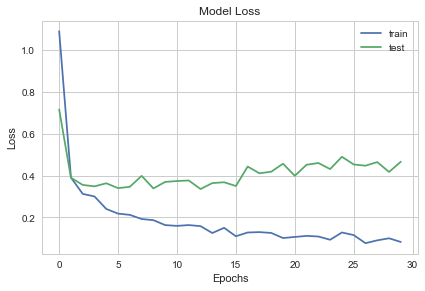

In [71]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

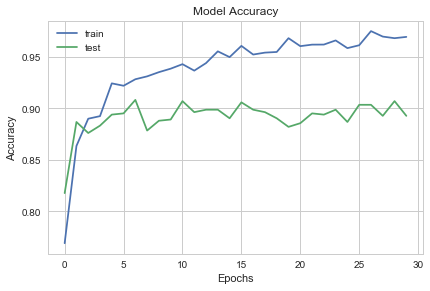

In [72]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [103]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

In [104]:
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

Model trained from ResNet-50


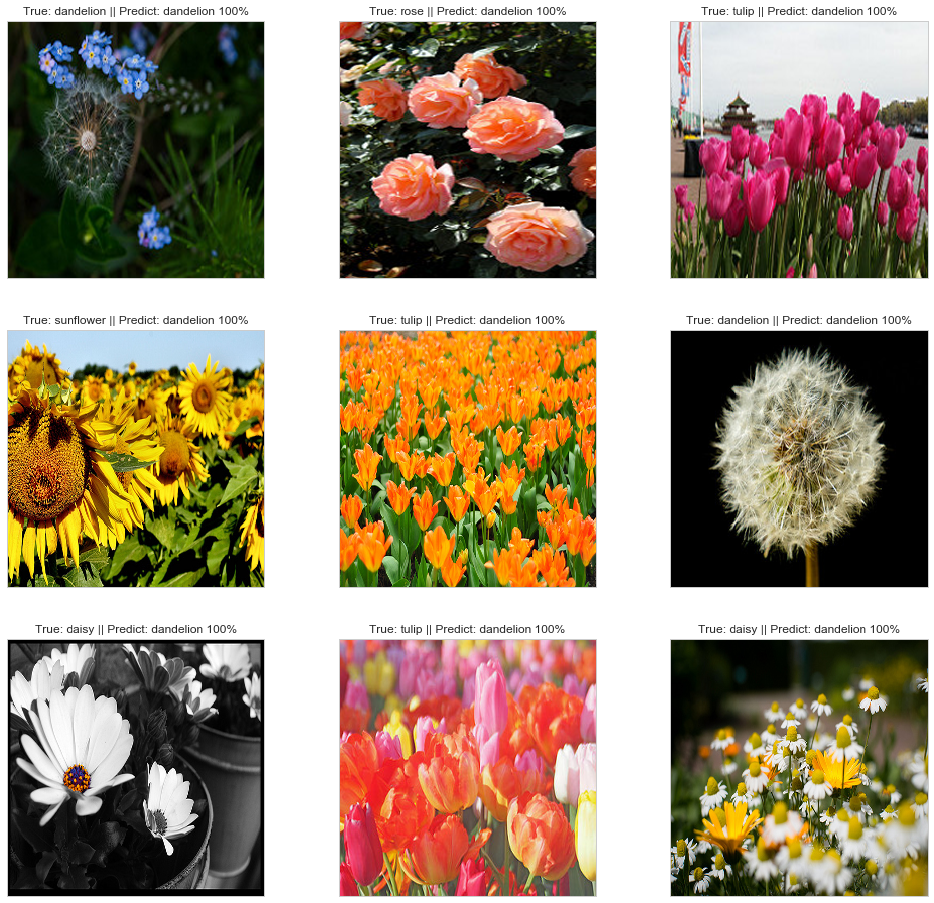

In [106]:
print("Model trained from ResNet-50")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(860)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
  category_idx = return_name(val_labels[idx])
  
  pred, prob = predict_val(val_data[idx], model)
  plt.title('True: %s || Predict: %s %d%%' % (categories[category_idx], categories[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()